# Group analysis of full frame fluorescent data
* 4/13/2024 setup

In [1]:
import os
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.classes import database

In [61]:
savedir = "/data2/gergely/invivo_DATA/sleep/summaries/psd_summaries/"

In [2]:
db = database.ExperimentDatabase()
dendritic_trials = [927, 935, 934, 929, 936, 931, 937, 932]
somatic_trials = [745, 740, 749, 762, 761, 760, 885, 890, 898]

In [3]:
somatic_tseries = []
for trial in somatic_trials:
    somatic_tseries.append(database.fetch_trial(trial)["tSeries_path"])

dendritic_tseries = []
for trial in dendritic_trials:
    dendritic_tseries.append(database.fetch_trial(trial)["tSeries_path"])

In [4]:
def aggregate_psd_data(directories):
    """
    Aggregate 'psd_data.csv' from various subdirectories listed in 'directories'.

    Args:
        directories (list): A list of directories to search for 'psd_data.csv'.

    Returns:
        pd.DataFrame: A DataFrame containing all the data from 'psd_data.csv' files.
    """
    df_somatic_psd_data = (
        pd.DataFrame()
    )  # Initialize an empty DataFrame to hold all data

    # Loop over each directory in the list
    for directory in directories:
        # Walk through all subdirectories in the current directory
        for dirpath, dirnames, filenames in os.walk(directory):
            # Check if 'psd_data.csv' is in the list of filenames
            if "psd_data.csv" in filenames:
                # Construct the full path to the file
                file_path = os.path.join(dirpath, "psd_data.csv")
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path)
                # Append this DataFrame to the master DataFrame
                df_somatic_psd_data = pd.concat(
                    [df_somatic_psd_data, df], ignore_index=True
                )
                break  # Assuming only one 'psd_data.csv' per directory in the list

    return df_somatic_psd_data

In [17]:
df_somatic_psd_data = aggregate_psd_data(somatic_tseries)
df_dendritic_psd_data = aggregate_psd_data(dendritic_tseries)

In [60]:
df_dendritic_psd_data.shape, df_somatic_psd_data.shape

((8, 3), (9, 3))

In [19]:
def clean_convert_and_mean_somatic(row):
    # Remove brackets and convert the remaining string to a float array
    nrem_numbers = np.fromstring(row["nrem_filt_psd"].strip("[]"), sep=" ")
    awake_numbers = np.fromstring(row["awake_filt_psd"].strip("[]"), sep=" ")
    nrem_mean = np.mean(nrem_numbers)
    awake_mean = np.mean(awake_numbers)
    return pd.Series([nrem_mean, awake_mean])


def clean_convert_and_mean_dendritic(row):
    # Remove brackets and convert the remaining string to a float array
    immob_numbers = np.fromstring(row["immob_filt_psd"].strip("[]"), sep=" ")
    mob_numbers = np.fromstring(row["mob_filt_psd"].strip("[]"), sep=" ")
    immob_mean = np.mean(immob_numbers)
    mob_mean = np.mean(mob_numbers)
    return pd.Series([immob_mean, mob_mean])

In [8]:
mean_df_somatic_psd_data = df_somatic_psd_data.apply(clean_convert_and_mean_somatic, axis=1)
mean_df_somatic_psd_data.columns = ["nrem_mean", "awake_mean"]
mean_df_somatic_psd_data["data_dir"] = df_somatic_psd_data["data_dir"]

In [34]:
mean_df_dendritic_psd_data = df_dendritic_psd_data.apply(
    clean_convert_and_mean_dendritic, axis=1
)
mean_df_dendritic_psd_data.columns = ["immob_mean", "mob_mean"]
mean_df_dendritic_psd_data["data_dir"] = df_dendritic_psd_data["data_dir"]

In [36]:
cell_type = ["GC", "MC", "MC", "GC", "MC", "MC", "GC", "GC", "GC"]
cort_condition = ["ctrl", "ctrl", "ctrl", "ctrl", "ctrl", "cort", "cort", "cort"]

In [37]:
mean_df_somatic_psd_data["cell_type"] = cell_type
mean_df_dendritic_psd_data["Cort"] = cort_condition
mean_df_dendritic_psd_data

,immob_mean,mob_mean,data_dir,Cort
0,201.372490,15.107599,/data2/gergely/invivo_DATA/sleep/140503_2/1_16...,ctrl
1,1046.169216,73.482788,/data2/gergely/invivo_DATA/sleep/140503_2/1_17...,ctrl
2,596.747249,48.456951,/data2/gergely/invivo_DATA/sleep/140503_2/1_18...,ctrl
3,1778.412589,280.530357,/data2/gergely/invivo_DATA/sleep/140503_3/1_16...,ctrl
4,2472.058811,443.096997,/data2/gergely/invivo_DATA/sleep/140503_3/1_17...,ctrl
5,880.500731,1586.967924,/data2/gergely/invivo_DATA/sleep/140502_5/1_16...,cort
6,2613.753229,1626.141063,/data2/gergely/invivo_DATA/sleep/140502_5/1_17...,cort
7,714.006578,2382.339016,/data2/gergely/invivo_DATA/sleep/140302_3/1_18...,cort


In [ ]:
long_somatic_data = pd.melt(
    mean_df_somatic_psd_data,
    id_vars=["data_dir", "cell_type"],
    value_vars=["nrem_mean", "awake_mean"],
    var_name="condition",
    value_name="mean_psd",
)

long_somatic_data["condition"] = long_somatic_data["condition"].map(
    {"nrem_mean": "NREM", "awake_mean": "Awake"}
)

long_somatic_data.convert_dtypes()
long_somatic_data["cell_type"] = long_somatic_data["cell_type"].astype("category")
long_somatic_data["condition"] = long_somatic_data["condition"].astype("category")
long_somatic_data["data_dir"] = long_somatic_data["data_dir"].astype(str)
long_somatic_data

In [38]:
long_dendritic_data = pd.melt(
    mean_df_dendritic_psd_data,
    id_vars=["data_dir", "Cort"],
    value_vars=["immob_mean", "mob_mean"],
    var_name="condition",
    value_name="mean_psd",
)

long_dendritic_data["condition"] = long_dendritic_data["condition"].map(
    {"immob_mean": "Immobility", "mob_mean": "Mobility"}
)

long_dendritic_data.convert_dtypes()
long_dendritic_data["Cort"] = long_dendritic_data["Cort"].astype("category")
long_dendritic_data["condition"] = long_dendritic_data["condition"].astype("category")
long_dendritic_data["data_dir"] = long_dendritic_data["data_dir"].astype(str)
long_dendritic_data

,data_dir,Cort,condition,mean_psd
0,/data2/gergely/invivo_DATA/sleep/140503_2/1_16...,ctrl,Immobility,201.372490
1,/data2/gergely/invivo_DATA/sleep/140503_2/1_17...,ctrl,Immobility,1046.169216
2,/data2/gergely/invivo_DATA/sleep/140503_2/1_18...,ctrl,Immobility,596.747249
3,/data2/gergely/invivo_DATA/sleep/140503_3/1_16...,ctrl,Immobility,1778.412589
4,/data2/gergely/invivo_DATA/sleep/140503_3/1_17...,ctrl,Immobility,2472.058811
5,/data2/gergely/invivo_DATA/sleep/140502_5/1_16...,cort,Immobility,880.500731
6,/data2/gergely/invivo_DATA/sleep/140502_5/1_17...,cort,Immobility,2613.753229
7,/data2/gergely/invivo_DATA/sleep/140302_3/1_18...,cort,Immobility,714.006578
8,/data2/gergely/invivo_DATA/sleep/140503_2/1_16...,ctrl,Mobility,15.107599
9,/data2/gergely/invivo_DATA/sleep/140503_2/1_17...,ctrl,Mobility,73.482788


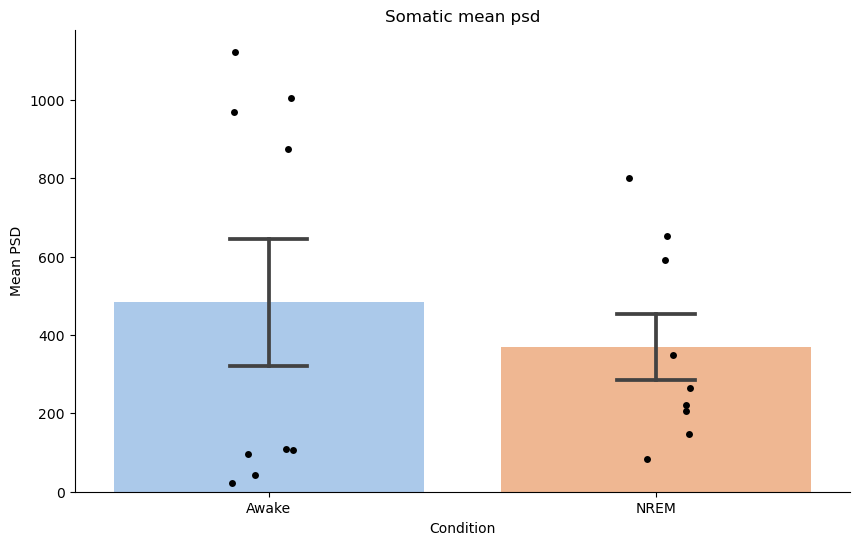

In [62]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x="condition",
    y="mean_psd",
    data=long_somatic_data,
    errorbar="se",
    palette="pastel",
    estimator=np.mean,
    capsize=0.2,
)
sns.stripplot(
    x="condition",
    y="mean_psd",
    data=long_somatic_data,
    color="black",
    size=5,
    jitter=True,
)
sns.despine()
plt.title("Somatic mean psd")
plt.xlabel("Condition")
plt.ylabel("Mean PSD")
plt.savefig(join(savedir, "somatic_mean_psd.png"), dpi=300)
plt.show()

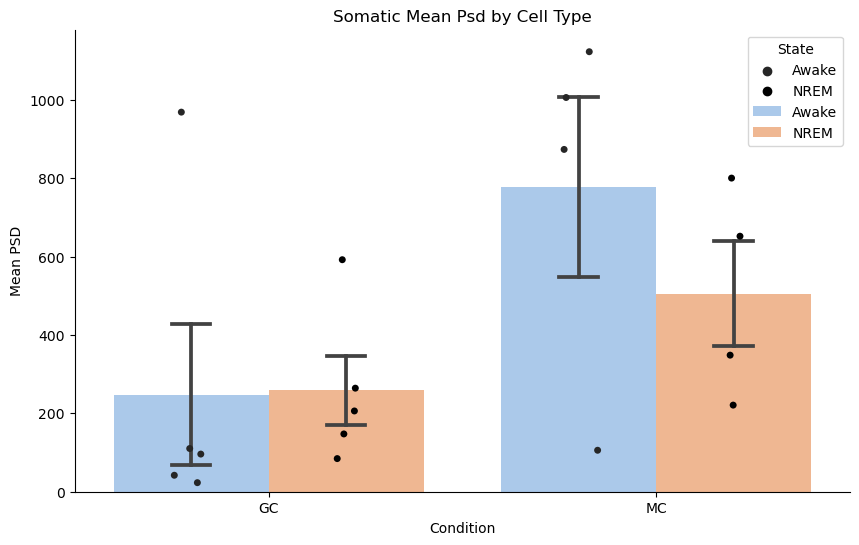

In [63]:
# Plotting with 'cell_type' as hue
plt.figure(figsize=(10, 6))
sns.barplot(
    x="cell_type",
    y="mean_psd",
    hue="condition",
    data=long_somatic_data,
    errorbar="se",
    palette="pastel",
    estimator=np.mean,
    capsize=0.1,
)
sns.stripplot(
    x="cell_type",
    y="mean_psd",
    hue="condition",
    data=long_somatic_data,
    palette="dark:black",
    size=5,
    jitter=True,
    dodge=True,
)
sns.despine()

plt.title("Somatic Mean Psd by Cell Type")
plt.xlabel("Condition")
plt.ylabel("Mean PSD")
plt.legend(title="Cell Type")

# Optional: Adjust legend location and aesthetics if needed
plt.legend(loc="upper right", title="State")
plt.savefig(join(savedir, "somatic_mean_psd_by_cell_type.png"), dpi=300)
plt.show()

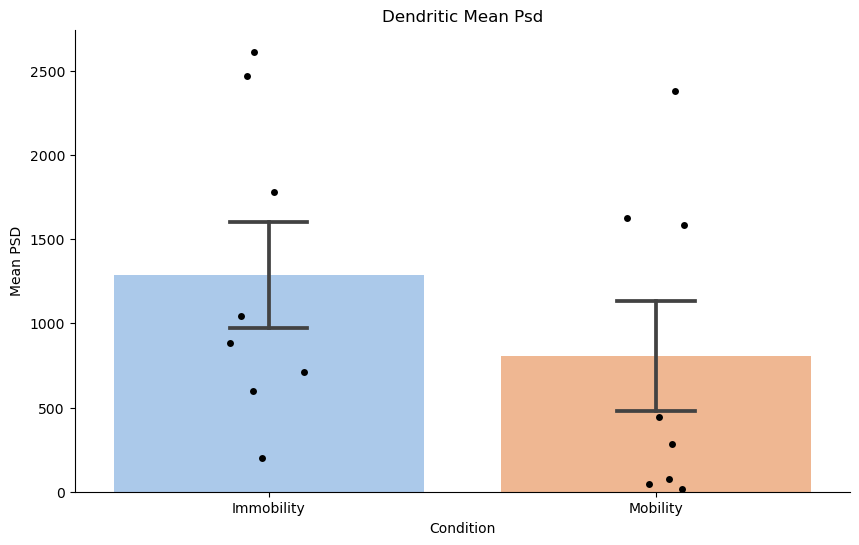

In [64]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x="condition",
    y="mean_psd",
    data=long_dendritic_data,
    errorbar="se",
    palette="pastel",
    estimator=np.mean,
    capsize=0.2,
)
sns.stripplot(
    x="condition",
    y="mean_psd",
    data=long_dendritic_data,
    color="black",
    size=5,
    jitter=True,
)
sns.despine()
plt.title("Dendritic Mean Psd")
plt.xlabel("Condition")
plt.ylabel("Mean PSD")
plt.savefig(join(savedir, "dendritic_mean_psd.png"), dpi=300)
plt.show()

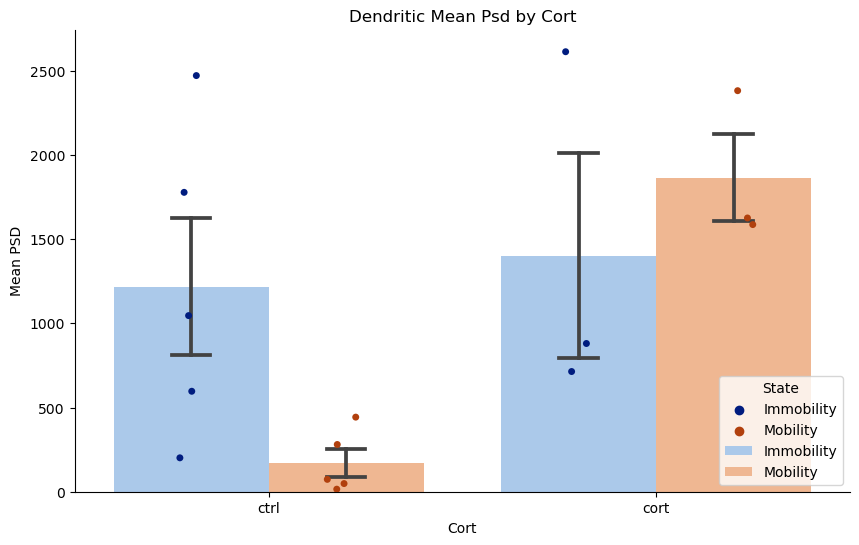

In [65]:
# Define the order for the 'Cort' categories
cort_order = ["ctrl", "cort"]

# Define the order for the 'condition' hues
condition_order = ["Immobility", "Mobility"]  # Adjust based on your actual conditions

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Cort",
    y="mean_psd",
    hue="condition",
    data=long_dendritic_data,
    errorbar="se",
    palette="pastel",
    estimator=np.mean,
    capsize=0.1,
    order=cort_order,  # Controls the order of x-axis categories
    hue_order=condition_order,  # Controls the order of hues within each category
)
sns.stripplot(
    x="Cort",
    y="mean_psd",
    hue="condition",
    data=long_dendritic_data,
    palette="dark",
    size=5,
    jitter=True,
    dodge=True,
    order=cort_order,  # Match the order for consistency
    hue_order=condition_order,  # Match the hue order for consistency
)
sns.despine()

plt.title("Dendritic Mean Psd by Cort")
plt.xlabel("Cort")
plt.ylabel("Mean PSD")
plt.legend(title="State", loc="lower right")
plt.savefig(join(savedir, "dendritic_mean_psd_by_cort.png"), dpi=300)
plt.show()